In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, roc_auc_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, label_binarize


In [2]:
df = pd.read_csv("Debernardi et al 2020 data.csv")
print(df.shape)
df.head(7)

(590, 14)


,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.54000,41.088000,NaN
5,S103,Cohort2,BPTB,53,M,1,NaN,NaN,NaN,0.84825,0.003393,62.12600,59.793000,NaN
6,S104,Cohort2,BPTB,70,M,1,NaN,NaN,NaN,0.62205,0.174381,152.27700,117.516000,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sample_id                590 non-null    object 
 1   patient_cohort           590 non-null    object 
 2   sample_origin            590 non-null    object 
 3   age                      590 non-null    int64  
 4   sex                      590 non-null    object 
 5   diagnosis                590 non-null    int64  
 6   stage                    199 non-null    object 
 7   benign_sample_diagnosis  208 non-null    object 
 8   plasma_CA19_9            350 non-null    float64
 9   creatinine               590 non-null    float64
 10  LYVE1                    590 non-null    float64
 11  REG1B                    590 non-null    float64
 12  TFF1                     590 non-null    float64
 13  REG1A                    306 non-null    float64
dtypes: float64(6), int64(2), o

In [4]:
df.isna().sum()

sample_id                    0
patient_cohort               0
sample_origin                0
age                          0
sex                          0
diagnosis                    0
stage                      391
benign_sample_diagnosis    382
plasma_CA19_9              240
creatinine                   0
LYVE1                        0
REG1B                        0
TFF1                         0
REG1A                      284
dtype: int64

In [5]:
# preprocessing

df['stage'] = df['stage'].fillna('Unknown')
df['benign_sample_diagnosis'] = df['benign_sample_diagnosis'].fillna('Unknown')
df['REG1A'] = df['REG1A'].fillna(df['REG1A'].mean())

imputer = KNNImputer(n_neighbors=3)
df['plasma_CA19_9'] = imputer.fit_transform(df[['plasma_CA19_9']])


encoder = LabelEncoder()
df['stage'] = encoder.fit_transform(df['stage'])
df['sample_origin'] = encoder.fit_transform(df['sample_origin'])


df['benign_sample_diagnosis'] = df['benign_sample_diagnosis'].str.strip()
df['benign_sample_diagnosis'] = encoder.fit_transform(df['benign_sample_diagnosis'])

df = pd.get_dummies(df, columns=['sex', 'patient_cohort'], drop_first=True)

columns = ['plasma_CA19_9', 'creatinine', 'LYVE1', 'REG1B', 'TFF1']
scaler = StandardScaler()
df[columns] = scaler.fit_transform(df[columns])

df.drop(columns=['sample_id'], inplace=True)

df


,sample_origin,age,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A,sex_M,patient_cohort_Cohort2
0,0,33,1,8,47,-3.436293e-01,1.529927,-0.631661,-0.299975,0.055876,1262.000000,False,False
1,0,81,1,8,47,-6.082196e-17,0.183680,-0.298597,-0.088256,-0.384680,228.407000,False,False
2,0,51,1,8,47,-3.461438e-01,-0.117454,-0.849256,-0.047976,-0.135425,735.281222,True,True
3,0,61,1,8,47,-3.456088e-01,-0.241451,-0.890812,-0.261065,-0.450584,735.281222,True,True
4,0,62,1,8,47,-3.450738e-01,-1.003143,-0.891378,-0.235767,-0.551475,735.281222,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,0,68,3,7,47,-6.082196e-17,-0.524871,1.162636,0.226755,-0.071998,735.281222,True,True
586,0,71,3,7,47,-6.082196e-17,0.006542,1.536048,-0.483726,-0.348568,735.281222,False,True
587,0,63,3,7,47,-6.082196e-17,0.803662,1.342066,0.907324,-0.060005,735.281222,True,True
588,0,75,3,7,47,-6.082196e-17,0.750521,1.496923,0.480141,0.123466,735.281222,False,True


In [14]:
df.isna().sum()

sample_origin              0
age                        0
diagnosis                  0
stage                      0
benign_sample_diagnosis    0
plasma_CA19_9              0
creatinine                 0
LYVE1                      0
REG1B                      0
TFF1                       0
REG1A                      0
sex_M                      0
patient_cohort_Cohort2     0
dtype: int64

In [15]:
X = df.drop(columns=['diagnosis'])
y = df['diagnosis'] - 1
print(np.unique(y))

[0 1 2]


In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y, random_state=42)

In [17]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(413, 12)
(177, 12)
(413,)
(177,)


In [18]:
# grid search for XGB

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 2, 3, 4],
    'learning_rate': [0.01, 0.1, 0.15]
}

xgb_clf = XGBClassifier()

grid_xgb = GridSearchCV(xgb_clf, param_grid=param_grid_xgb, cv=5, n_jobs=-1)
grid_xgb.fit(x_train, y_train)

print(grid_xgb.best_params_)

{'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50}


In [19]:
# XGB accuracy with best parameter

best_xgb = XGBClassifier(**grid_xgb.best_params_)
best_xgb.fit(x_train, y_train)

y_pred = best_xgb.predict(x_test)
print('XGB accuracy =>', accuracy_score(y_test, y_pred))

XGB accuracy => 1.0


In [20]:
# grid search for RandomForest

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
}

rf_clf = RandomForestClassifier()

grid_rf = GridSearchCV(rf_clf, param_grid=param_grid_rf, cv=5)
grid_rf.fit(x_train, y_train)
print(grid_rf.best_params_)

{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}


In [21]:
best_rf = RandomForestClassifier(**grid_rf.best_params_)
best_rf.fit(x_train, y_train)

y_pred = best_rf.predict(x_test)
print('Random forest accuracy =>', accuracy_score(y_test, y_pred))

Random forest accuracy => 1.0


In [32]:
# Grid search for SVC

param_svc = {'C': [5, 10, 30, 50, 70, 100, 130]}

clf_svc = SVC()

grid_svc = GridSearchCV(SVC(), param_grid=param_svc, cv=5)
grid_svc.fit(x_train, y_train)

best_svc_param = grid_svc.best_params_
print(best_svc_param)

{'C': 130}


In [31]:
# SVC accuracy with best parameter

best_svc = SVC(**best_svc_param)

best_svc.fit(x_train, y_train)
y_pred = best_svc.predict(x_test)
print('SVC accuracy =>', accuracy_score(y_test, y_pred))

SVC accuracy => 0.7627118644067796


In [30]:
# Grid search for KNN

param_knn = {
    'n_neighbors': [3, 5, 7]
}

clf_knn = KNeighborsClassifier()

grid_knn = GridSearchCV(clf_knn, param_grid=param_knn, cv=5)
grid_knn.fit(x_train, y_train)

best_knn_param = grid_knn.best_params_
print(best_knn_param)

{'n_neighbors': 3}


In [28]:
# KNN accuracy with best parameter

best_knn = KNeighborsClassifier(**best_knn_param)
best_knn.fit(x_train, y_train)

y_pred = best_knn.predict(x_test)
print('KNN accuracy =>',accuracy_score(y_test, y_pred))


KNN accuracy => 0.8192090395480226


In [35]:
# Stacking one

stacking_1 = StackingClassifier(
    estimators= [
        ('rf', best_rf),
        ('xgb', best_xgb),
        ('svm', best_svc),
        ('knn', best_knn)
    ],
    final_estimator = LogisticRegression()
)

stacking_1.fit(x_train, y_train)
y_pred_1 = stacking_1.predict(x_test)
print("Accuracy (Stacking 1) =>", accuracy_score(y_test, y_pred_1))
print(classification_report(y_test, y_pred_1))

Accuracy (Stacking 1) => 0.9943502824858758
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        55
           1       1.00      0.98      0.99        62
           2       1.00      1.00      1.00        60

    accuracy                           0.99       177
   macro avg       0.99      0.99      0.99       177
weighted avg       0.99      0.99      0.99       177



In [36]:
# Stacking two

stacking_2 = StackingClassifier(
    estimators= [
        ('svm', best_svc),
        ('knn', best_knn)
    ],
    final_estimator = GradientBoostingClassifier()
)

stacking_2.fit(x_train, y_train)
y_pred_2 = stacking_2.predict(x_test)
print("Accuracy (Stacking 2) =>", accuracy_score(y_test, y_pred_2))
print(classification_report(y_test, y_pred_2))

Accuracy (Stacking 2) => 0.8418079096045198
              precision    recall  f1-score   support

           0       0.82      0.75      0.78        55
           1       0.98      0.92      0.95        62
           2       0.74      0.85      0.79        60

    accuracy                           0.84       177
   macro avg       0.85      0.84      0.84       177
weighted avg       0.85      0.84      0.84       177



Average for Stacking 1: 1.0
Average for Stacking 2: 0.95


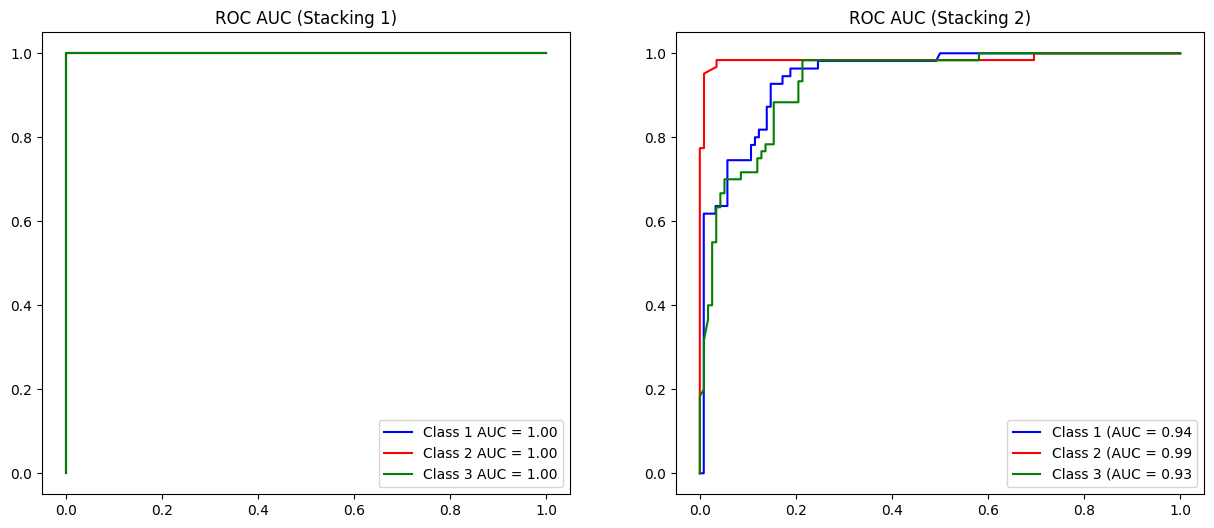

In [66]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])


y_score_1 = stacking_1.predict_proba(x_test)
y_score_2 = stacking_2.predict_proba(x_test)

plt.figure(figsize=(15, 6))

colors = ['blue', 'red', 'green']

plt.subplot(1, 2, 1)
for i, color in enumerate(colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_1[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, label = f'Class {i + 1} AUC = {roc_auc:.2f}')
    
plt.title('ROC AUC (Stacking 1)')
plt.legend()

 
plt.subplot(1, 2, 2)
for i, color in enumerate(colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_2[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, label=f'Class {i + 1} (AUC = {roc_auc:.2f}')
    
plt.title('ROC AUC (Stacking 2)')
plt.legend()

print('Average for Stacking 1:', roc_auc_score(y_test_bin, y_score_1, average='macro'))
print('Average for Stacking 2:', f'{roc_auc_score(y_test_bin, y_score_2, average='macro'):.2f}')